In [979]:
import re
import pickle
import spacy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


target_names=['Negative',"Positive"]

[ref](https://www.atlantis-press.com/journals/nlpr/125954372/view#sec-s4_3)

[N-GRAM](https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/)

[Bangla NLTK](https://github.com/sagorbrur/bnlp)

# Data Loading

In [980]:
data = pd.read_csv('/kaggle/input/bangla-fsa/Bangla financial sentiment.csv',encoding='UTF-8')
data.head()

,Unnamed: 0.1,Unnamed: 0,Headline,label
0,0,0.0,তারল্যসংকট প্রতিদিনই জরিমানা দিচ্ছে শরিয়াহভিত্...,0
1,1,1.0,এবার বাংলাদেশের ঋণমান কমানোর কথা জানাল এসঅ্যান...,0
2,2,2.0,বৈশ্বিক মূল্যস্ফীতি কমবে প্রবৃদ্ধি কমে হবে ৩%,1
3,3,3.0,সংকটেও রেকর্ড মুনাফা লেনদেনে ফিরল শেয়ার,1
4,4,4.0,বিমার দাপট সপ্তাহজুড়ে কারসাজির সন্দেহ,0


In [981]:
data=data.drop(['Unnamed: 0.1',"Unnamed: 0"], axis=1)
data.head()

,Headline,label
0,তারল্যসংকট প্রতিদিনই জরিমানা দিচ্ছে শরিয়াহভিত্...,0
1,এবার বাংলাদেশের ঋণমান কমানোর কথা জানাল এসঅ্যান...,0
2,বৈশ্বিক মূল্যস্ফীতি কমবে প্রবৃদ্ধি কমে হবে ৩%,1
3,সংকটেও রেকর্ড মুনাফা লেনদেনে ফিরল শেয়ার,1
4,বিমার দাপট সপ্তাহজুড়ে কারসাজির সন্দেহ,0


In [982]:
# shuffle the DataFrame rows
data= data.sample(frac = 1)
data.tail()

,Headline,label
1039,দারিদ্র্য নিরসনের সাফল্য হুমকির মুখে,0
57,বৈদেশিক মুদ্রা ডলারের সরবরাহে ঘাটতি থাকায় তেল ...,0
911,হিমায়িত চিংড়ি রপ্তানিতে আশার আলো দেখছি,1
635,আশা দেখাচ্ছে খেলনা রপ্তানি,1
1716,ব্যাংকের ঊর্ধ্বতন কর্মকর্তাদের সম্পদ বিবরণী জম...,0


In [983]:
data.isna().sum()

Headline    0
label       0
dtype: int64

In [984]:
len(data[data.duplicated()])

5

In [985]:
df=data
df = df.drop_duplicates()
print(df.head())
print(df.shape)

                                               Headline  label
1278                 বিশেষ তহবিল ঘোষণায় চাঙা শেয়ারবাজার      1
1608                          পুঁজিবাজারে সূচকের বড় পতন      0
571                  জ্বালানি তেলের দাম ১০০ ডলারের নিচে      1
1435  বাজারে এলো জীবাণুনাশক নেরোল্যাক এক্সেল ভাইরাস ...      1
1587                ১শ টাকার বীমায় ২ লাখ টাকা ক্ষতিপূরণ      0
(1831, 2)


# Data Cleaning

In [986]:
# Data cleaning function
# def process_headline(headline):
#     #removing unnecessary punctuation an digit
#     headline = re.sub('[^\u0980-\u09FF]',' ',str(headline)) 
#     return headline

In [987]:
# Apply the function into the dataframe
# df['cleaned'] = df['Headline'].apply(process_headline)  

# df.head()

In [988]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [989]:
df['cleaned'] = df.Headline.apply(lambda x: preprocessing(str(x)))
# df.reset_index(drop=True, inplace=True)
df.head()

,Headline,label,cleaned
1278,বিশেষ তহবিল ঘোষণায় চাঙা শেয়ারবাজার,1,বিশেষ তহবিল ঘোষণায় চাঙা শেয়ারবাজার
1608,পুঁজিবাজারে সূচকের বড় পতন,0,পুঁজিবাজারে সূচকের বড় পতন
571,জ্বালানি তেলের দাম ১০০ ডলারের নিচে,1,জ্বালানি তেলের দাম ডলারের নিচে
1435,বাজারে এলো জীবাণুনাশক নেরোল্যাক এক্সেল ভাইরাস ...,1,বাজারে এলো জীবাণুনাশক নেরোল্যাক এক্সেল ভাইরাস ...
1587,১শ টাকার বীমায় ২ লাখ টাকা ক্ষতিপূরণ,0,শ টাকার বীমায় লাখ টাকা ক্ষতিপূরণ


In [990]:
test_size_ratio=[0.1,0.2,0.3]
for test_size in test_size_ratio:
     print(f'For Test Ratio:{1-test_size}, Validation Ratio: {test_size}')

For Test Ratio:0.9, Validation Ratio: 0.1
For Test Ratio:0.8, Validation Ratio: 0.2
For Test Ratio:0.7, Validation Ratio: 0.3


# Data Split Function

In [991]:
def dataset_split(feature_space,sentiment,test_split_ratio):

    X_train,X_test,y_train,y_test = train_test_split(feature_space,sentiment,
                                                  test_size =test_split_ratio,random_state =0)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])
  
    return X_train,X_test,y_train,y_test

# tfidf function

In [992]:
# def calc_gram_tfidf(Headline,gram):
#     tfidf = TfidfVectorizer(ngram_range=gram,use_idf=True,tokenizer=lambda x: x.split()) 
#     X = tfidf.fit_transform(Headline)
    
#     return tfidf,X

In [993]:
def calc_gram_tfidf(Headline,gram):
    tfidf = TfidfVectorizer(ngram_range=gram,use_idf=True,tokenizer=lambda x: x.split()) 
#     X = tfidf.fit_transform(Headline)
    X=pd.DataFrame(tfidf.fit_transform(Headline).todense())
    
    return tfidf,X

# Checking Imbalance

In [994]:
def check_imbalance(y_train):
    plt.pie(pd.value_counts(y_train), 
        labels=['Label 0 (Negative Tweets)', 'Label 1 (Positive Tweets)'], 
        autopct='%0.1f%%')
    plt.axis('equal')
    plt.show()

# Creating and Evaluating Models


In [995]:
def evaluate_model(cm,y_test,y_test_pred):
    sns.heatmap(cm,cmap="Blues",annot=True,linewidths=0.5,linecolor="red",fmt=".0f",xticklabels=target_names, yticklabels=target_names,)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    # plt.savefig('ensemble_confusion_matrix.png', transparent=False, dpi=500)
    plt.show()
    
    print(classification_report(y_test,y_test_pred,target_names=target_names))

In [996]:
# Functions to print scores
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Training Scores: Accuracy={acc*100}, F1-Score={f1*100}')
    
def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Validation Scores: Accuracy={acc*100}, F1-Score={f1*100}')
    return acc,f1

In [997]:
def Find_Best_model(Val_acc_list, Val_f1_list,model):
    df = pd.DataFrame(list(zip(model,Val_acc_list,Val_f1_list)),
                 columns=["model","accuracy","f1-score"] )
    print(df)
    print(f'Best Accuracy={max(Val_acc_list) * 100}, Model={model[Val_acc_list.index(max(Val_acc_list))]}')
    print(f'Best F1-Score={max(Val_f1_list) * 100}, Model={model[Val_f1_list.index(max(Val_f1_list))]}')
#     print("Maximum Accuracy: ",(max(Val_acc_list))) 
#     print("Maximum Index position: ",Val_acc_list.index(max(Val_acc_list))) 

# Model Creation

In [998]:
models=[]
def model_performace(X_train,X_test,y_train,y_test):
    
    Val_acc_list = []
    Val_f1_list = []
    
    print("Model Name: SVC")
    clf = GridSearchCV(SVC(), {
        "kernel": ['linear','rbf'],
        'max_iter': [100,500,1000],
        'C': [1,2,3],
        'tol':[0.001,0.0001,0.00001]
        }, return_train_score=False)
    clf.fit(X_train,y_train)
    print(clf.best_params_)
    SVCmodel = SVC(C=clf.best_params_['C'], max_iter=clf.best_params_['max_iter'], 
                tol=clf.best_params_['tol'],kernel=clf.best_params_['kernel'],
                   probability=True, random_state = 0)
    models.append(SVCmodel)
    SVCmodel.fit(X_train, y_train)
    y_train_pred = SVCmodel.predict(X_train)
    y_test_pred = SVCmodel.predict(X_test)
    training_scores(y_train, y_train_pred)
    acc,f1=validation_scores(y_test, y_test_pred)
    Val_acc_list.append(acc)
    Val_f1_list.append(f1)
    cm=confusion_matrix(y_test,y_test_pred )
    evaluate_model(cm,y_test,y_test_pred)
    file = open('svc.pickle','wb')
    pickle.dump(SVCmodel, file)
    file.close()
    
    print("Model Name: Logistic Regression")
    clf = GridSearchCV(LogisticRegression(solver="liblinear",random_state=42,n_jobs=-1), {
        "penalty": ['l1','l2','elasticnet','None'],
        'max_iter': [100,500,1000],
        'C': [1,2,3],
        'tol':[0.001,0.0001,0.00001]
        }, return_train_score=False)
    clf.fit(X_train,y_train)  
    print(clf.best_params_)
    LRmodel = LogisticRegression(C=clf.best_params_['C'], max_iter=clf.best_params_['max_iter'], 
                tol=clf.best_params_['tol'],penalty=clf.best_params_['penalty'],
                    solver="liblinear",random_state=42,n_jobs=-1)
    models.append(LRmodel)
    LRmodel.fit(X_train, y_train)
    y_train_pred = LRmodel.predict(X_train)
    y_test_pred =LRmodel.predict(X_test)
    training_scores(y_train, y_train_pred)
    acc,f1=validation_scores(y_test, y_test_pred)
    Val_acc_list.append(acc)
    Val_f1_list.append(f1)
    cm=confusion_matrix(y_test,y_test_pred )
    evaluate_model(cm,y_test,y_test_pred)
    file = open('LRmodel.pickle','wb')
    pickle.dump(LRmodel, file)
    file.close()

  
    print("Model Name:Random Forest")
    clf = GridSearchCV(RandomForestClassifier(), {
        "n_estimators": [10,100,200],
        "criterion": ['gini', 'entropy', 'log_loss']
        
        }, return_train_score=False)
    clf.fit(X_train,y_train)  
    print(clf.best_params_)
    rf=RandomForestClassifier(n_estimators=clf.best_params_['n_estimators'],criterion=clf.best_params_['criterion']
                              ,n_jobs=-1, random_state=42)
    models.append(rf)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    training_scores(y_train, y_train_pred)
    acc,f1=validation_scores(y_test, y_test_pred)
    Val_acc_list.append(acc)
    Val_f1_list.append(f1)
    cm=confusion_matrix(y_test,y_test_pred )
    evaluate_model(cm,y_test,y_test_pred)
    file = open('rf.pickle','wb')
    pickle.dump(rf, file)
    file.close()
    
    
   
    y_axis = Val_acc_list
    x_axis = ["SVC","LR","RF"]
#     x_axis = ["Linear SVC","RBF SVC","LR","DT","KNN","MNB","RF","ADB","BAG","GB"]
    color=['blue','orange','green']
#     color=['blue','orange','green','red','purple',"brown","pink","gray","olive",'cyan']
    plt.bar(x_axis, y_axis,color=color)
    plt.title('Comparison of Accuracy Between Models')
    plt.xlabel('Model Name')
    plt.ylabel('Accuracy')
    plt.figure(figsize=(8,6))
    plt.show()
    
    y_axis = Val_f1_list
    plt.bar(x_axis, y_axis, color=color)
    plt.title('Comparison of F1-Score Between Models')
    plt.xlabel('Model Name')
    plt.ylabel('F1-Score')
    plt.figure(figsize=(8,6))
    plt.show()
    
    
    Find_Best_model(Val_acc_list, Val_f1_list,x_axis)

In [999]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidfModel = TfidfVectorizer()
# print(tfidfModel.fit_transform(df['Headline']))

In [1000]:
# print(tfidfModel.fit_transform(df['Headline']).todense())

In [1001]:
# tfidf_df = pd.DataFrame(tfidfModel.fit_transform(df['Headline']).todense())
# tfidf_df.columns = sorted(tfidfModel.vocabulary_)
# tfidf_df

In [1002]:
# x=tfidf_df
# y=df[['label']]

In [1003]:
# x

In [1004]:
# y

In [1005]:
# from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=20)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# PCA with Dimentionality Reduction

In [1006]:
# from sklearn.decomposition import PCA

# # converting into 3000 columns
# pca=PCA(n_components=1000)

# X_train=pca.fit_transform(X_train)

# print(X_train.shape)

# X_test=pca.transform(X_test) # transforming test data along with train data

In [1007]:
# print("Total Variance explained:",sum(pca.explained_variance_ratio_*100))

In [1008]:
# pca.explained_variance_ratio_*100

In [1009]:
# np.cumsum(pca.explained_variance_ratio_*100)

In [1010]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
# plt.xlabel('Number of components')
# plt.ylabel('Explained variance')

In [1011]:
# def Find_PCA(X_train):
#     max_feature=min(X_train.shape)
#     print(max_feature)
#     for i in range (2,max_feature):
#         pca=PCA(n_components=i)
#         X_pca=pca.fit_transform(X_train)
# #         print(X_pca.shape)
#         print("Total Variance explained:",sum(pca.explained_variance_ratio_*100))
#         if(sum(pca.explained_variance_ratio_*100)>=100):
#             print("GOOTCHA")
#             break
#     print("Expected Component:{i}")
        

# Find_PCA(X_train)    

# Unigram Model

Gram Name: Unigram
Feature Size :======> 3622

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1831 
	Training		 1464 
	Test			 367


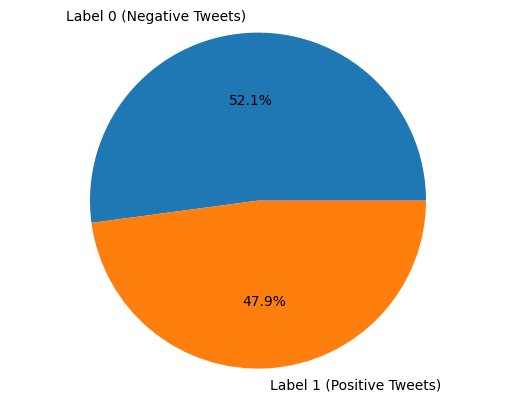

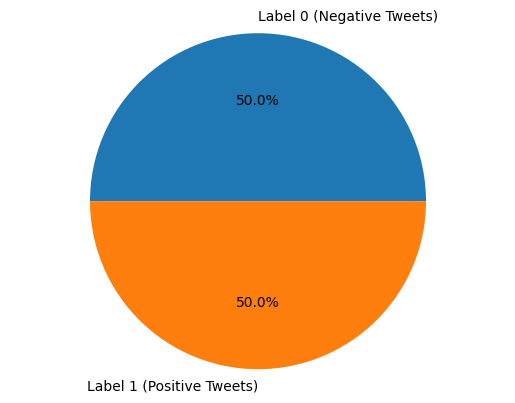

(1526, 3622) (1526,)


In [1012]:
print(f'Gram Name: Unigram')
fidf,feature = calc_gram_tfidf(df.cleaned,(1,1))
labels = df.label
X_train,X_test,y_train,y_test = dataset_split(feature,labels,0.2)
check_imbalance(y_train)
smote = SMOTE(n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train,y_train.values)
check_imbalance(y_train)
print(X_train.shape, y_train.shape)

(1526, 1500)
Total Variance explained: 99.99999999999999
[  0.93313281   1.64772145   2.29957    ... 100.         100.
 100.        ]
(367, 1500)


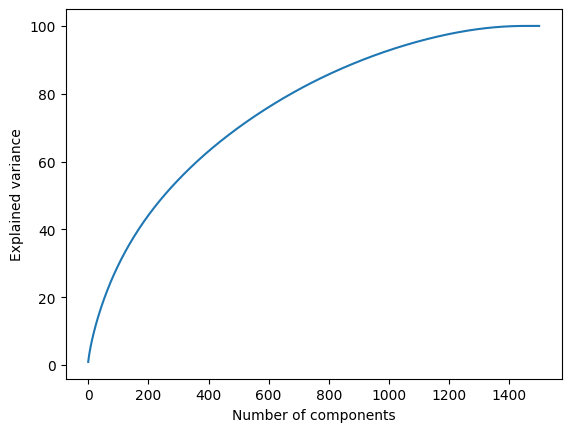

In [1014]:
# converting into 1000 columns
pca=PCA(n_components=1500)

X_train_pca=pca.fit_transform(X_train)

print(X_train_pca.shape)

print("Total Variance explained:",sum(pca.explained_variance_ratio_*100))
print(np.cumsum(pca.explained_variance_ratio_*100))
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

X_test_pca=pca.transform(X_test) # transforming test data along with train data
print (X_test_pca.shape)



Model Name: SVC
{'C': 1, 'kernel': 'rbf', 'max_iter': 1000, 'tol': 0.001}
Training Scores: Accuracy=99.2, F1-Score=99.2
Validation Scores: Accuracy=76.3, F1-Score=78.0


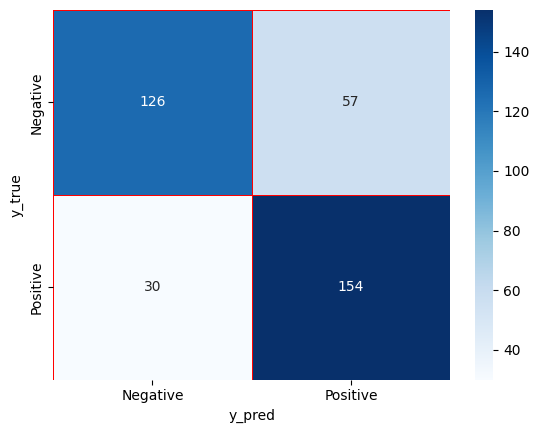

              precision    recall  f1-score   support

    Negative       0.81      0.69      0.74       183
    Positive       0.73      0.84      0.78       184

    accuracy                           0.76       367
   macro avg       0.77      0.76      0.76       367
weighted avg       0.77      0.76      0.76       367

Model Name: Logistic Regression
{'C': 3, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.001}
Training Scores: Accuracy=96.6, F1-Score=96.6
Validation Scores: Accuracy=76.6, F1-Score=75.7


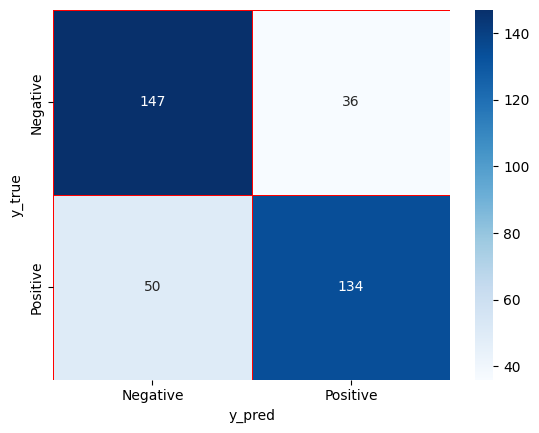

              precision    recall  f1-score   support

    Negative       0.75      0.80      0.77       183
    Positive       0.79      0.73      0.76       184

    accuracy                           0.77       367
   macro avg       0.77      0.77      0.77       367
weighted avg       0.77      0.77      0.77       367

Model Name:Random Forest
{'criterion': 'entropy', 'n_estimators': 100}
Training Scores: Accuracy=99.9, F1-Score=99.9
Validation Scores: Accuracy=57.49999999999999, F1-Score=48.3


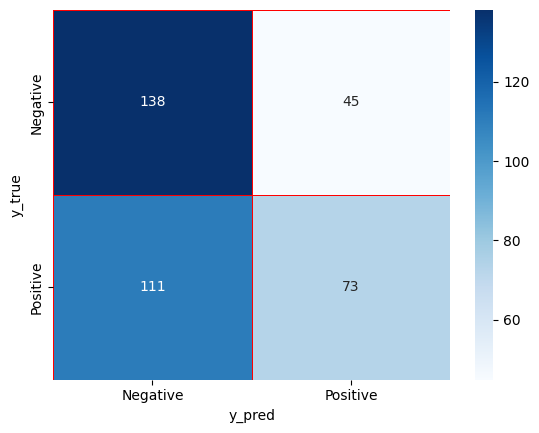

              precision    recall  f1-score   support

    Negative       0.55      0.75      0.64       183
    Positive       0.62      0.40      0.48       184

    accuracy                           0.57       367
   macro avg       0.59      0.58      0.56       367
weighted avg       0.59      0.57      0.56       367



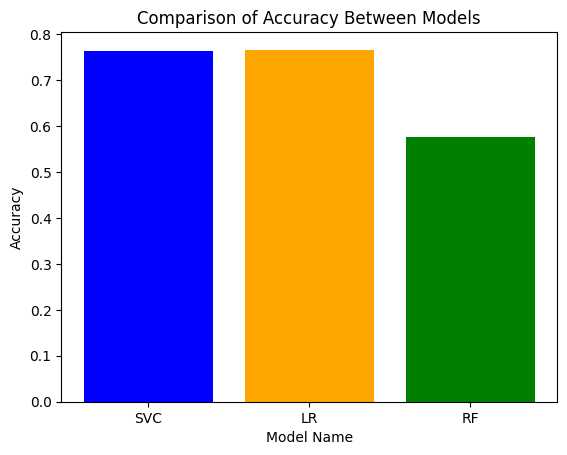

<Figure size 800x600 with 0 Axes>

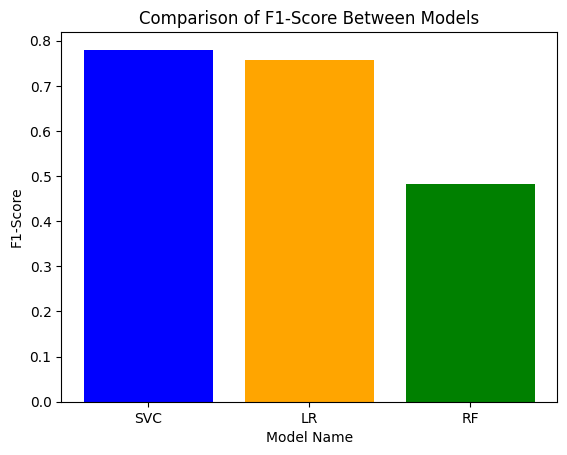

<Figure size 800x600 with 0 Axes>

  model  accuracy  f1-score
0   SVC     0.763     0.780
1    LR     0.766     0.757
2    RF     0.575     0.483
Best Accuracy=76.6, Model=LR
Best F1-Score=78.0, Model=SVC


In [1015]:
model_performace(X_train_pca,X_test_pca,y_train,y_test) 

# Unigram & Bi-gram

Gram Name: Unigram
Feature Size :======> 11971

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1831 
	Training		 1464 
	Test			 367


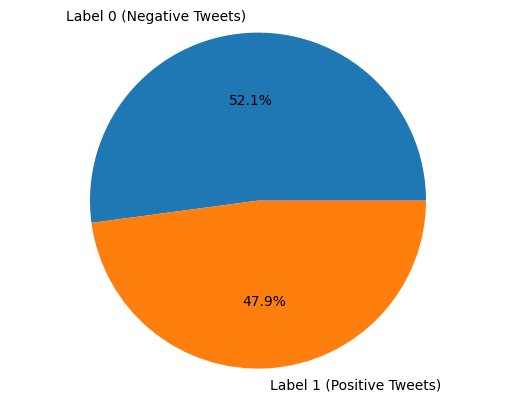

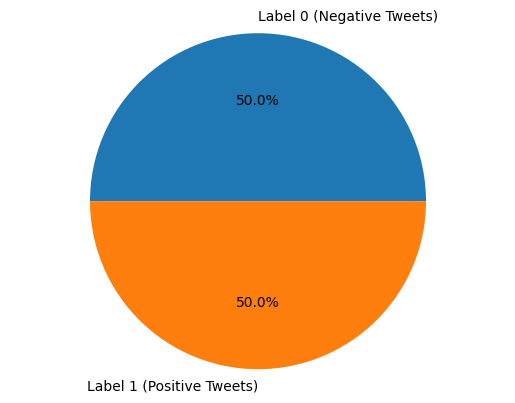

(1526, 11971) (1526,)


In [1016]:
print(f'Gram Name: Unigram')
fidf,feature = calc_gram_tfidf(df.cleaned,(1,2))
labels = df.label
X_train,X_test,y_train,y_test = dataset_split(feature,labels,0.2)
check_imbalance(y_train)
smote = SMOTE(n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train,y_train.values)
check_imbalance(y_train)
print(X_train.shape, y_train.shape)

(1526, 1500)
Total Variance explained: 100.00000000000018
[  0.53208808   0.93140301   1.32482785 ... 100.         100.
 100.        ]
(367, 1500)


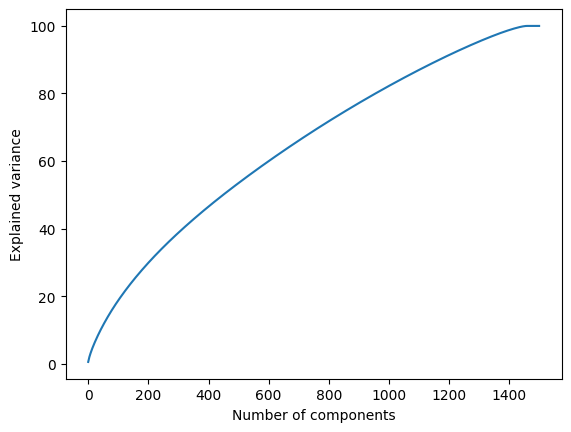

In [1020]:
# converting into 1000 columns
pca=PCA(n_components=1500)

X_train_pca=pca.fit_transform(X_train)

print(X_train_pca.shape)

print("Total Variance explained:",sum(pca.explained_variance_ratio_*100))
print(np.cumsum(pca.explained_variance_ratio_*100))
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

X_test_pca=pca.transform(X_test) # transforming test data along with train data
print (X_test_pca.shape)


Model Name: SVC
{'C': 3, 'kernel': 'linear', 'max_iter': 500, 'tol': 0.001}
Training Scores: Accuracy=99.9, F1-Score=99.9
Validation Scores: Accuracy=74.7, F1-Score=74.7


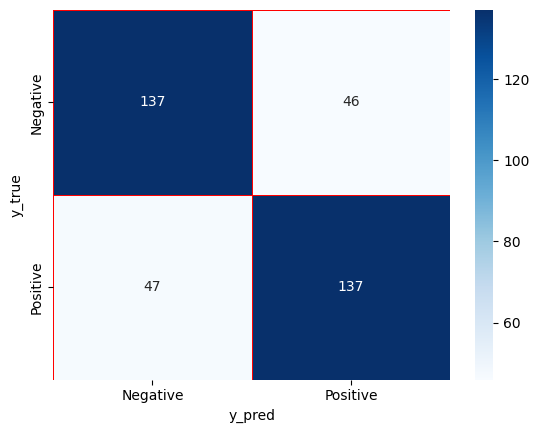

              precision    recall  f1-score   support

    Negative       0.74      0.75      0.75       183
    Positive       0.75      0.74      0.75       184

    accuracy                           0.75       367
   macro avg       0.75      0.75      0.75       367
weighted avg       0.75      0.75      0.75       367

Model Name: Logistic Regression
{'C': 3, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.001}
Training Scores: Accuracy=99.6, F1-Score=99.6
Validation Scores: Accuracy=74.9, F1-Score=74.2


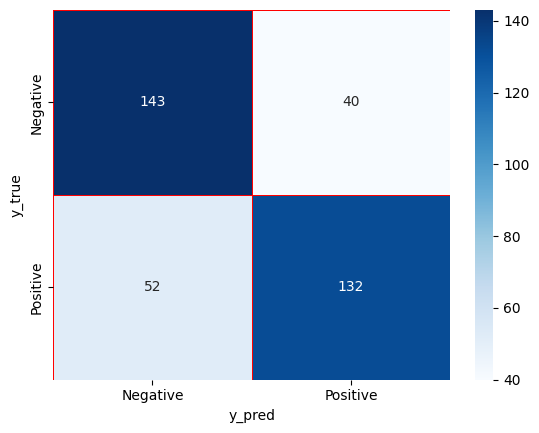

              precision    recall  f1-score   support

    Negative       0.73      0.78      0.76       183
    Positive       0.77      0.72      0.74       184

    accuracy                           0.75       367
   macro avg       0.75      0.75      0.75       367
weighted avg       0.75      0.75      0.75       367

Model Name:Random Forest
{'criterion': 'entropy', 'n_estimators': 200}
Training Scores: Accuracy=99.9, F1-Score=99.9
Validation Scores: Accuracy=51.5, F1-Score=67.0


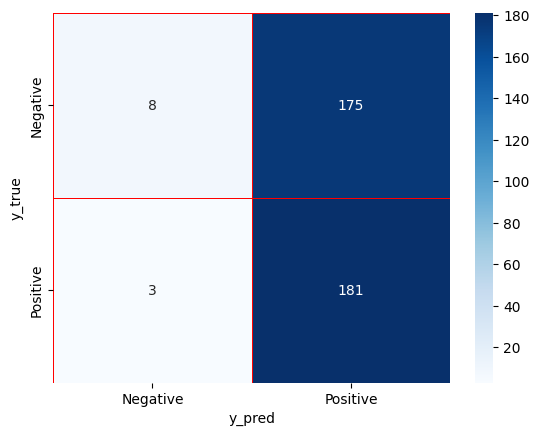

              precision    recall  f1-score   support

    Negative       0.73      0.04      0.08       183
    Positive       0.51      0.98      0.67       184

    accuracy                           0.51       367
   macro avg       0.62      0.51      0.38       367
weighted avg       0.62      0.51      0.38       367



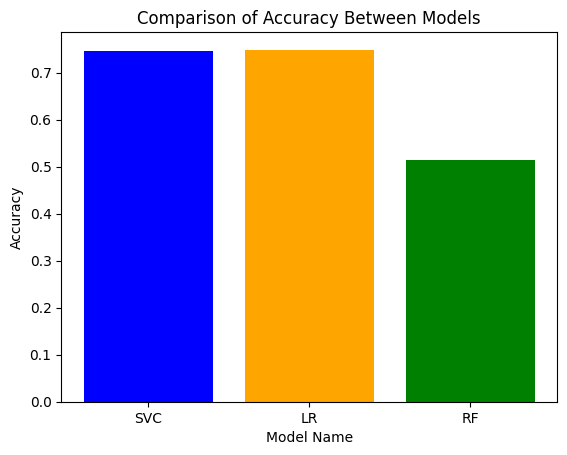

<Figure size 800x600 with 0 Axes>

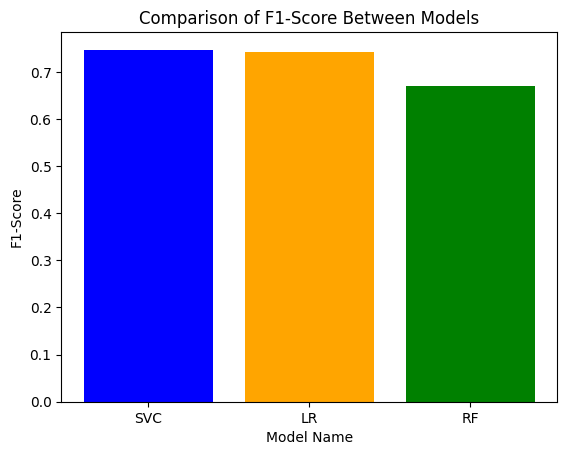

<Figure size 800x600 with 0 Axes>

  model  accuracy  f1-score
0   SVC     0.747     0.747
1    LR     0.749     0.742
2    RF     0.515     0.670
Best Accuracy=74.9, Model=LR
Best F1-Score=74.7, Model=SVC


In [1021]:
model_performace(X_train_pca,X_test_pca,y_train,y_test) 

# Unigram & Trigram

Feature Size :======> 19638

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1831 
	Training		 1464 
	Test			 367


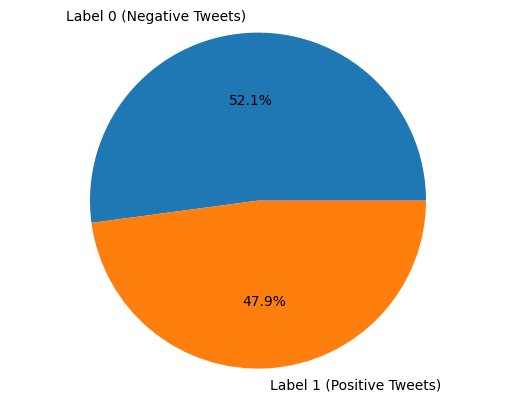

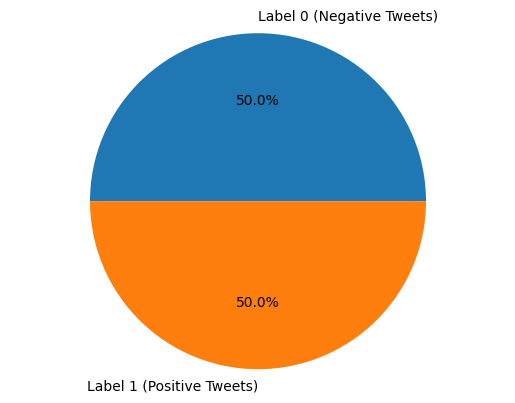

(1526, 19638) (1526,)


In [1022]:
fidf,feature = calc_gram_tfidf(df.cleaned,(1,3))
labels = df.label
X_train,X_test,y_train,y_test = dataset_split(feature,labels,0.2)
check_imbalance(y_train)
smote = SMOTE(n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train,y_train.values)
check_imbalance(y_train)
print(X_train.shape, y_train.shape)

(1526, 1500)
Total Variance explained: 100.00000000000006
[  0.38502904   0.70492899   1.00180383 ... 100.         100.
 100.        ]
(367, 1500)


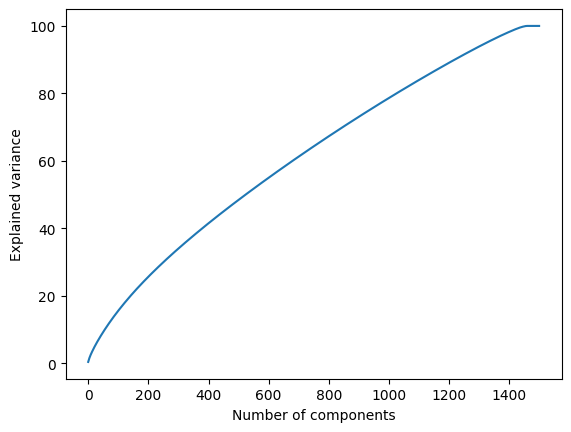

In [1023]:
pca=PCA(n_components=1500)

X_train_pca=pca.fit_transform(X_train)

print(X_train_pca.shape)

print("Total Variance explained:",sum(pca.explained_variance_ratio_*100))
print(np.cumsum(pca.explained_variance_ratio_*100))
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

X_test_pca=pca.transform(X_test) # transforming test data along with train data
print (X_test_pca.shape)


Model Name: SVC
{'C': 2, 'kernel': 'linear', 'max_iter': 500, 'tol': 0.001}
Training Scores: Accuracy=99.9, F1-Score=99.9
Validation Scores: Accuracy=73.8, F1-Score=73.3


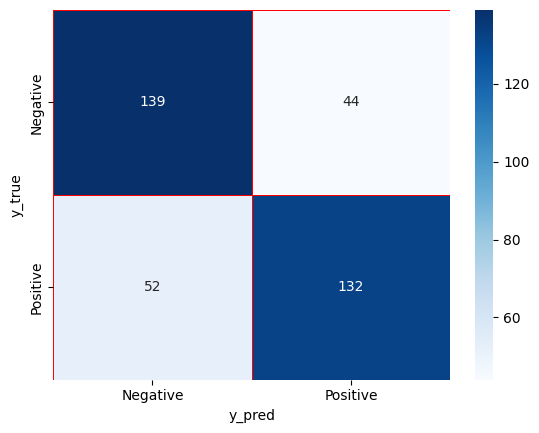

              precision    recall  f1-score   support

    Negative       0.73      0.76      0.74       183
    Positive       0.75      0.72      0.73       184

    accuracy                           0.74       367
   macro avg       0.74      0.74      0.74       367
weighted avg       0.74      0.74      0.74       367

Model Name: Logistic Regression
{'C': 2, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.001}
Training Scores: Accuracy=99.7, F1-Score=99.7
Validation Scores: Accuracy=74.4, F1-Score=73.3


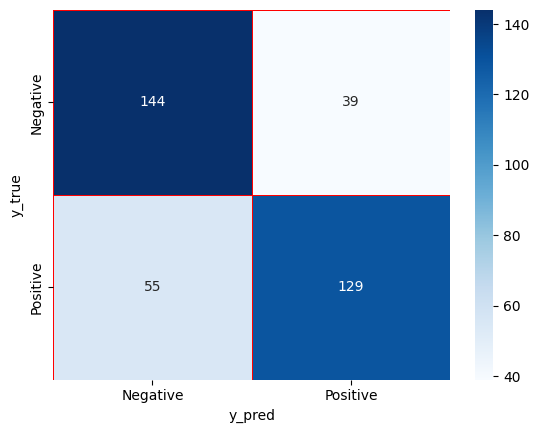

              precision    recall  f1-score   support

    Negative       0.72      0.79      0.75       183
    Positive       0.77      0.70      0.73       184

    accuracy                           0.74       367
   macro avg       0.75      0.74      0.74       367
weighted avg       0.75      0.74      0.74       367

Model Name:Random Forest
{'criterion': 'entropy', 'n_estimators': 200}
Training Scores: Accuracy=99.9, F1-Score=99.9
Validation Scores: Accuracy=50.4, F1-Score=66.8


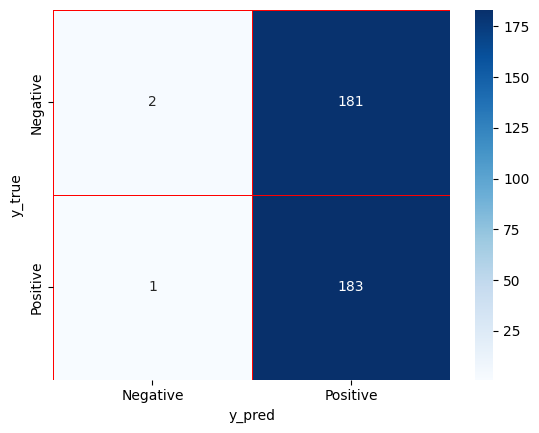

              precision    recall  f1-score   support

    Negative       0.67      0.01      0.02       183
    Positive       0.50      0.99      0.67       184

    accuracy                           0.50       367
   macro avg       0.58      0.50      0.34       367
weighted avg       0.58      0.50      0.35       367



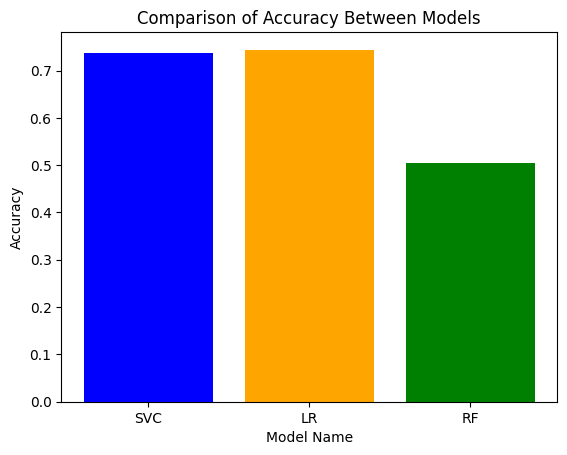

<Figure size 800x600 with 0 Axes>

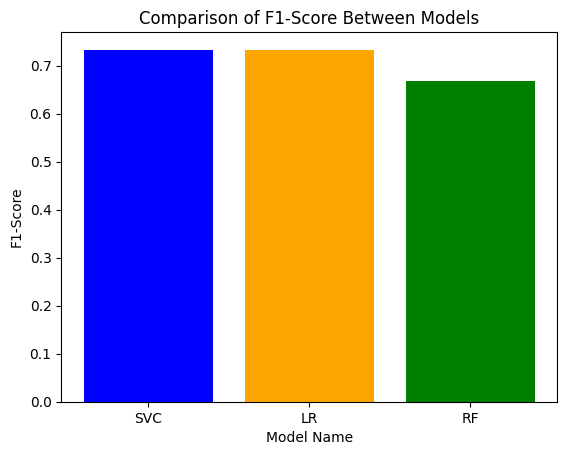

<Figure size 800x600 with 0 Axes>

  model  accuracy  f1-score
0   SVC     0.738     0.733
1    LR     0.744     0.733
2    RF     0.504     0.668
Best Accuracy=74.4, Model=LR
Best F1-Score=73.3, Model=SVC


In [1025]:
model_performace(X_train_pca,X_test_pca,y_train,y_test) 

# BI-GRAM

Feature Size :======> 8349

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1831 
	Training		 1464 
	Test			 367


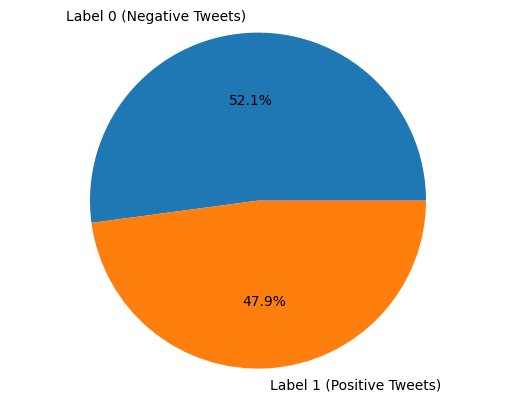

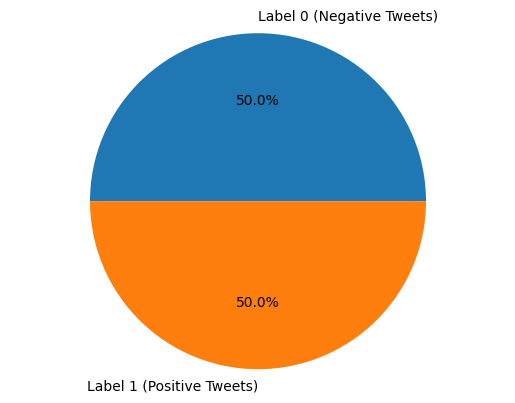

(1526, 8349) (1526,)


In [1029]:
fidf,feature = calc_gram_tfidf(df.cleaned,(2,2))
labels = df.label
X_train,X_test,y_train,y_test = dataset_split(feature,labels,0.2)
check_imbalance(y_train)
smote = SMOTE(n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train,y_train.values)
check_imbalance(y_train)
print(X_train.shape, y_train.shape)

(1526, 1500)
Total Variance explained: 99.99999999999844
[  0.3668342    0.69689031   0.98640485 ... 100.         100.
 100.        ]
(367, 1500)


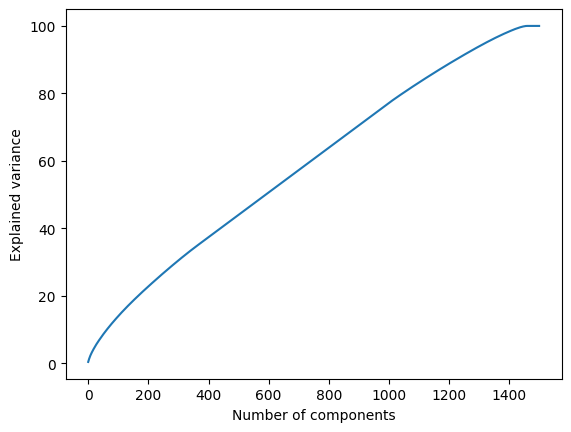

In [1030]:
pca=PCA(n_components=1500)

X_train_pca=pca.fit_transform(X_train)

print(X_train_pca.shape)

print("Total Variance explained:",sum(pca.explained_variance_ratio_*100))
print(np.cumsum(pca.explained_variance_ratio_*100))
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

X_test_pca=pca.transform(X_test) # transforming test data along with train data
print (X_test_pca.shape)

Model Name: SVC
{'C': 2, 'kernel': 'linear', 'max_iter': 500, 'tol': 0.001}
Training Scores: Accuracy=94.19999999999999, F1-Score=94.5
Validation Scores: Accuracy=61.0, F1-Score=68.4


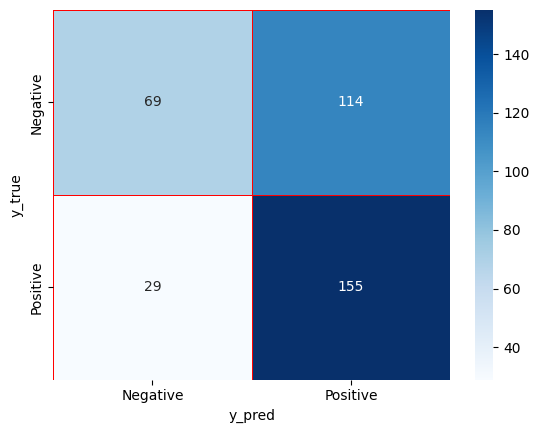

              precision    recall  f1-score   support

    Negative       0.70      0.38      0.49       183
    Positive       0.58      0.84      0.68       184

    accuracy                           0.61       367
   macro avg       0.64      0.61      0.59       367
weighted avg       0.64      0.61      0.59       367

Model Name: Logistic Regression
{'C': 3, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.001}
Training Scores: Accuracy=99.9, F1-Score=99.9
Validation Scores: Accuracy=63.5, F1-Score=53.1


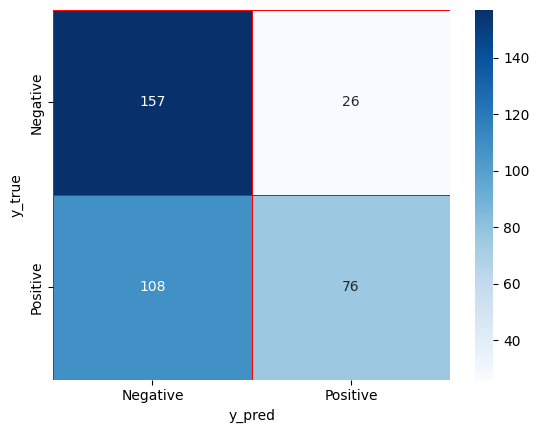

              precision    recall  f1-score   support

    Negative       0.59      0.86      0.70       183
    Positive       0.75      0.41      0.53       184

    accuracy                           0.63       367
   macro avg       0.67      0.64      0.62       367
weighted avg       0.67      0.63      0.62       367

Model Name:Random Forest
{'criterion': 'gini', 'n_estimators': 200}
Training Scores: Accuracy=99.9, F1-Score=99.9
Validation Scores: Accuracy=52.6, F1-Score=66.8


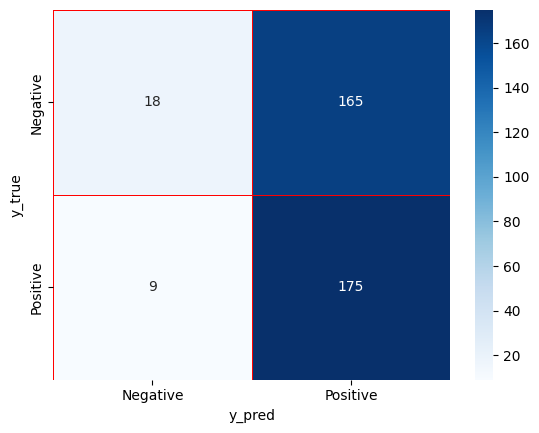

              precision    recall  f1-score   support

    Negative       0.67      0.10      0.17       183
    Positive       0.51      0.95      0.67       184

    accuracy                           0.53       367
   macro avg       0.59      0.52      0.42       367
weighted avg       0.59      0.53      0.42       367



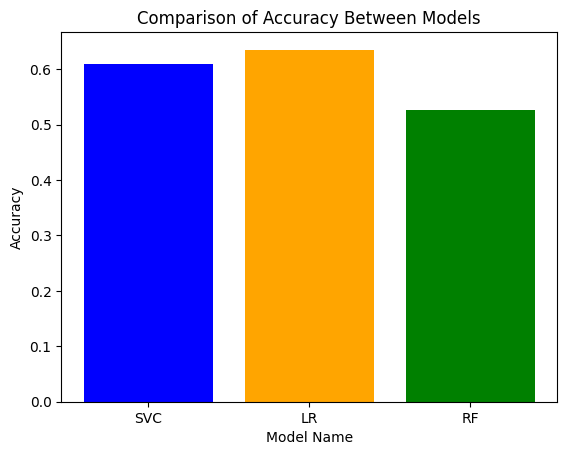

<Figure size 800x600 with 0 Axes>

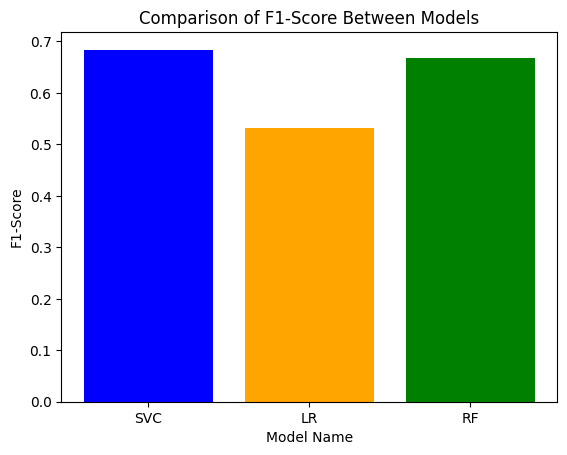

<Figure size 800x600 with 0 Axes>

  model  accuracy  f1-score
0   SVC     0.610     0.684
1    LR     0.635     0.531
2    RF     0.526     0.668
Best Accuracy=63.5, Model=LR
Best F1-Score=68.4, Model=SVC


In [1031]:
model_performace(X_train_pca,X_test_pca,y_train,y_test) 

# Tri-gram

Feature Size :======> 7667

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1831 
	Training		 1464 
	Test			 367


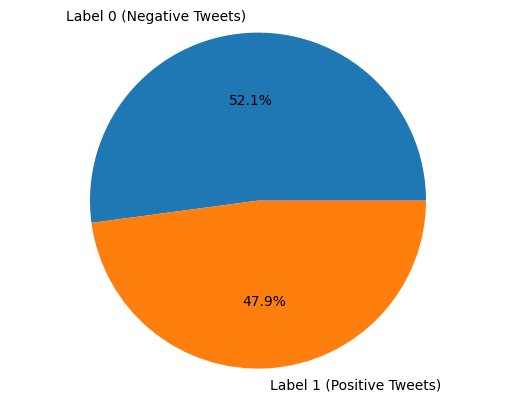

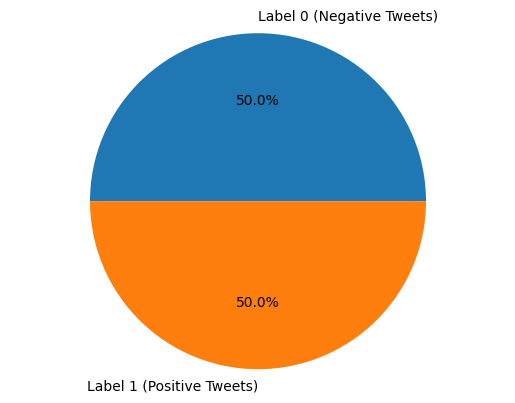

(1526, 7667) (1526,)


In [1032]:
fidf,feature = calc_gram_tfidf(df.cleaned,(3,3))
labels = df.label
X_train,X_test,y_train,y_test = dataset_split(feature,labels,0.2)
check_imbalance(y_train)
smote = SMOTE(n_jobs=-1)
X_train, y_train = smote.fit_resample(X_train,y_train.values)
check_imbalance(y_train)
print(X_train.shape, y_train.shape)

In [ ]:
pca=PCA(n_components=1500)

X_train_pca=pca.fit_transform(X_train)

print(X_train_pca.shape)

print("Total Variance explained:",sum(pca.explained_variance_ratio_*100))
print(np.cumsum(pca.explained_variance_ratio_*100))
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

X_test_pca=pca.transform(X_test) # transforming test data along with train data
print (X_test_pca.shape)

Model Name: SVC
{'C': 2, 'kernel': 'linear', 'max_iter': 500, 'tol': 0.001}
Training Scores: Accuracy=94.19999999999999, F1-Score=94.5
Validation Scores: Accuracy=61.0, F1-Score=68.4


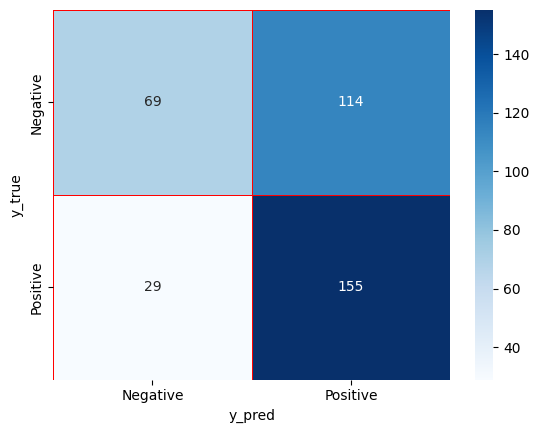

              precision    recall  f1-score   support

    Negative       0.70      0.38      0.49       183
    Positive       0.58      0.84      0.68       184

    accuracy                           0.61       367
   macro avg       0.64      0.61      0.59       367
weighted avg       0.64      0.61      0.59       367

Model Name: Logistic Regression
{'C': 3, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.001}
Training Scores: Accuracy=99.9, F1-Score=99.9
Validation Scores: Accuracy=63.5, F1-Score=53.1


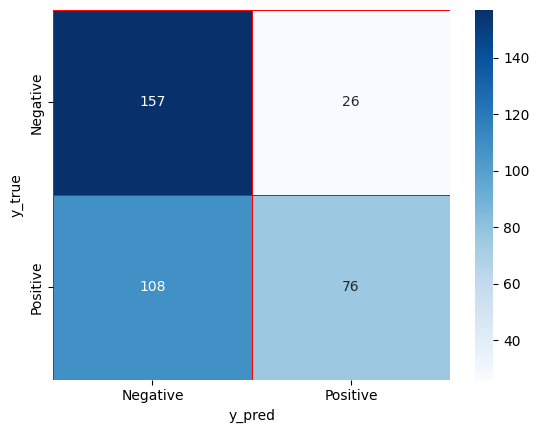

              precision    recall  f1-score   support

    Negative       0.59      0.86      0.70       183
    Positive       0.75      0.41      0.53       184

    accuracy                           0.63       367
   macro avg       0.67      0.64      0.62       367
weighted avg       0.67      0.63      0.62       367

Model Name:Random Forest
{'criterion': 'gini', 'n_estimators': 200}
Training Scores: Accuracy=99.9, F1-Score=99.9
Validation Scores: Accuracy=52.6, F1-Score=66.8


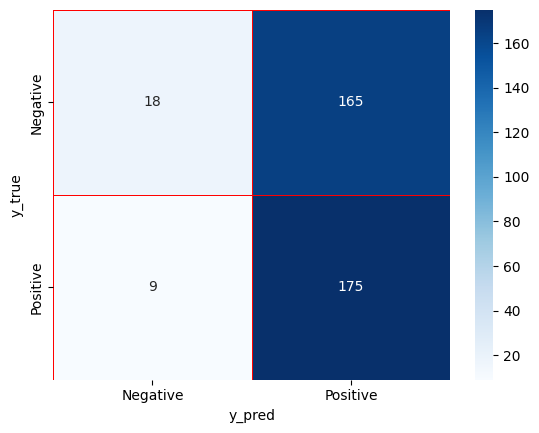

              precision    recall  f1-score   support

    Negative       0.67      0.10      0.17       183
    Positive       0.51      0.95      0.67       184

    accuracy                           0.53       367
   macro avg       0.59      0.52      0.42       367
weighted avg       0.59      0.53      0.42       367



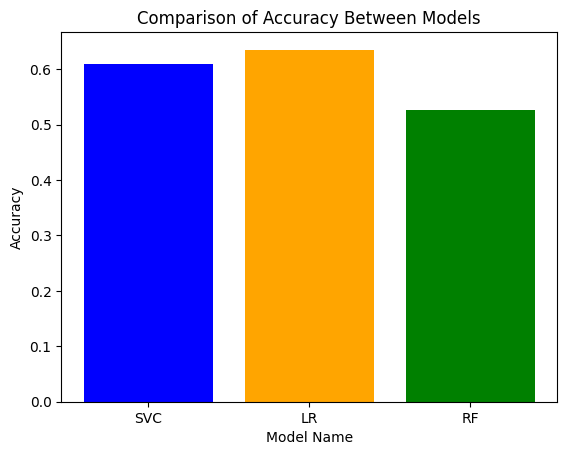

<Figure size 800x600 with 0 Axes>

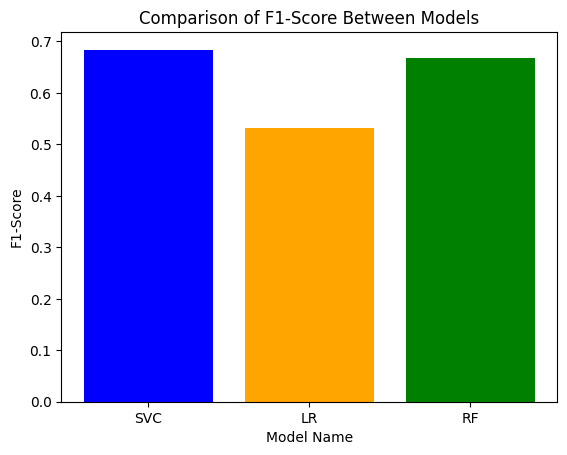

<Figure size 800x600 with 0 Axes>

  model  accuracy  f1-score
0   SVC     0.610     0.684
1    LR     0.635     0.531
2    RF     0.526     0.668
Best Accuracy=63.5, Model=LR
Best F1-Score=68.4, Model=SVC


In [1033]:
model_performace(X_train_pca,X_test_pca,y_train,y_test) 